# Training Model on IMDB Sample 

#### Import Libraries

In [1]:
import fastai
from fastai.vision import *

import pandas as pd
from torchvision import models
from visualization.modules import LayeredModule, get_nested_layers
from visualization.data import *
from visualization.image_proc import *
from visualization.interpret import NetLens

#### Define Paths

In [2]:
DATASET_PATH = Path('/home/jupyter/imdb-face-data/imdb_crop/imdb-sample/imdb-sample-data')
META_PATH = Path('/home/jupyter/imdb-face-data/imdb_crop/imdb-sample/imdb-sample-metafull.csv')
MODEL_PATH = Path('/home/jupyter/imdb-face-data/imdb_crop/imdb-sample/model')

#### Verify Images

In [3]:
verify_images(DATASET_PATH)

#### Read Metadata file in a Dataframe

In [4]:
meta = pd.read_csv(META_PATH)

#### Restructure the Dataframe

In [6]:
meta = meta[['absolute_path',
             'parent_path',
             'img_path',
             'name',
             'dob',
             'gender',
             'photo_taken',
             'age',
             'size_W_H',
             'mode']]
meta.head()

absolute_path  \
0  /home/jupyter/imdb-face-data/imdb_crop/40/nm22...   
1  /home/jupyter/imdb-face-data/imdb_crop/54/nm05...   
2  /home/jupyter/imdb-face-data/imdb_crop/47/nm00...   
3  /home/jupyter/imdb-face-data/imdb_crop/96/nm23...   
4  /home/jupyter/imdb-face-data/imdb_crop/96/nm11...   

                                    parent_path  \
0  40/nm2279940_rm2559819520_1984-7-27_2011.jpg   
1   54/nm0575754_rm2285080064_1950-3-4_1983.jpg   
2   47/nm0001347_rm2334775552_1948-2-5_2013.jpg   
3  96/nm2371196_rm1343148800_1982-2-24_2013.jpg   
4  96/nm1130496_rm3249586944_1970-7-21_2013.jpg   

                                    img_path              name   dob  gender  \
0  nm2279940_rm2559819520_1984-7-27_2011.jpg  Taylor Schilling  1984     0.0   
1   nm0575754_rm2285080064_1950-3-4_1983.jpg     Ofelia Medina  1950     0.0   
2   nm0001347_rm2334775552_1948-2-5_2013.jpg   Barbara Hershey  1948     0.0   
3  nm2371196_rm1343148800_1982-2-24_2013.jpg         Fala Chen  1982     0.0   
4  nm1130496_rm3249586944_1970-7-21_2013.jpg     Alysia Reiner  1970     0.0   

   photo_taken  age    size_W_H mode  
0         2011   27  (500, 500)  RGB  
1         1983   33  (500, 500)  RGB  
2         2013   65  (500, 500)  RGB  
3         2013   31  (500, 500)  RGB  
4         2013   43  (500, 500)  RGB

#### Plot some images

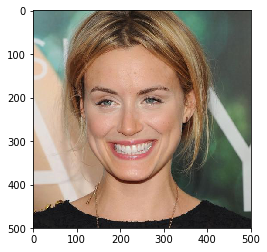

In [7]:
imagee= plt.imread(meta['absolute_path'][0])
plt.imshow(imagee)

In [14]:
def plot_images(df, n_images):
    sample = (i for i in df['absolute_path'][:n_images])
    cols = 5
    rows = n_images//cols
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(20, 14))

    for i in range(rows):
        for j in range(cols):
            rand_img = next(sample)
            img = plt.imread(rand_img)
            ax[i][j].imshow(img)
            ax[i][j].text(0, -30, img.shape, size=12, rotation=0,
                    ha="left", va="top", 
                    bbox=dict(boxstyle="round", ec='black', fc='white'))
    plt.setp(ax, xticks=[], yticks=[]);

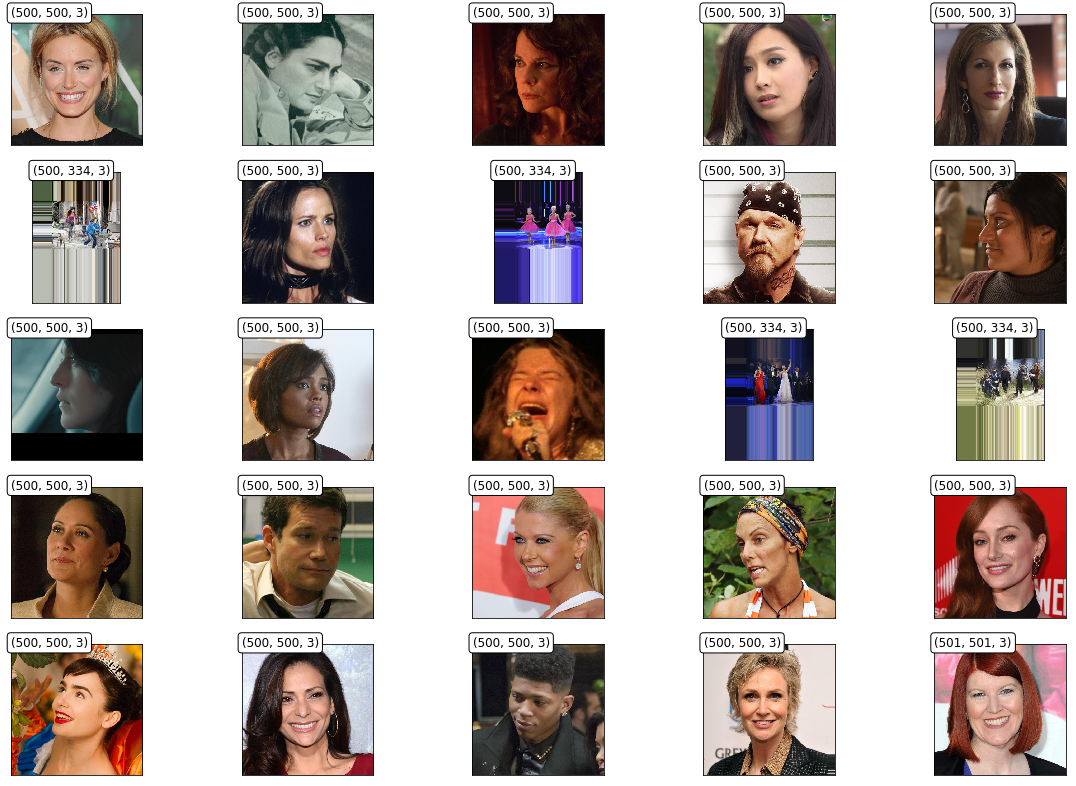

In [15]:
plot_images(meta, 25)

In [16]:
meta['size_W_H'].value_counts()

(500, 500)    13972
(334, 500)     2243
(333, 500)     2051
(501, 501)      970
Name: size_W_H, dtype: int64

In [28]:
df_334_500 = meta[meta['size_W_H'] == '(334, 500)']
df_333_500 = meta[meta['size_W_H'] == '(333, 500)']
df_500_500 = meta[meta['size_W_H'] == '(500, 500)']
df_501_501 = meta[meta['size_W_H'] == '(501, 501)']

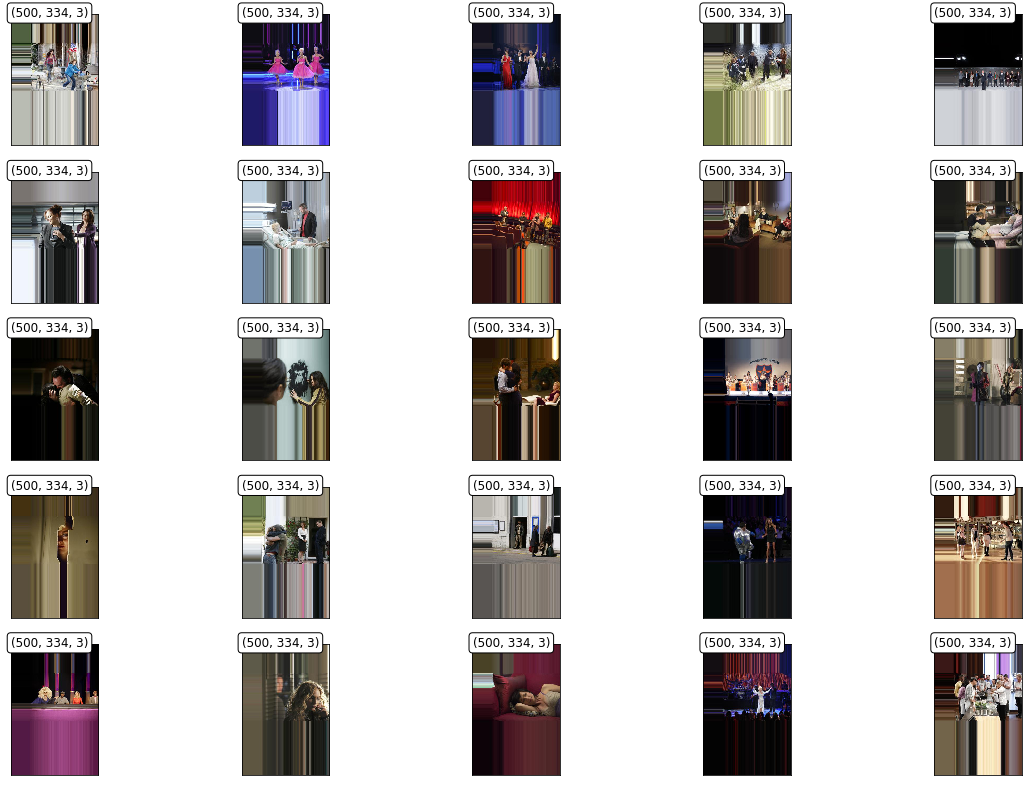

In [34]:
plot_images(df_334_500, 25)

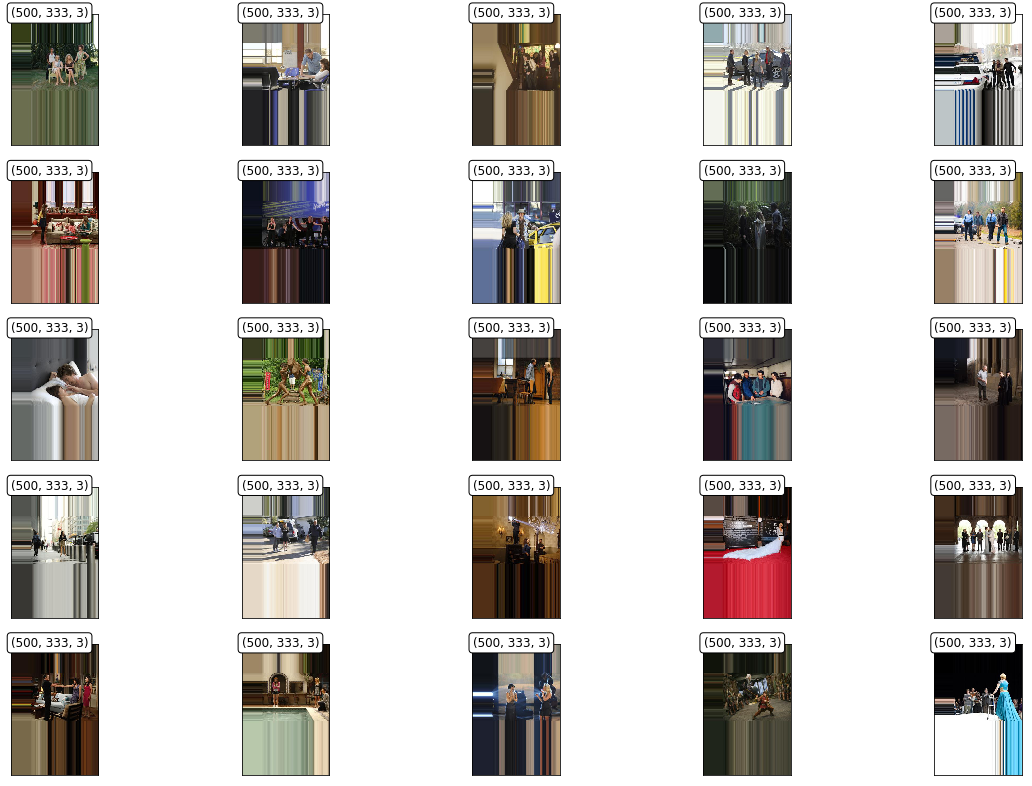

In [35]:
plot_images(df_333_500, 25)

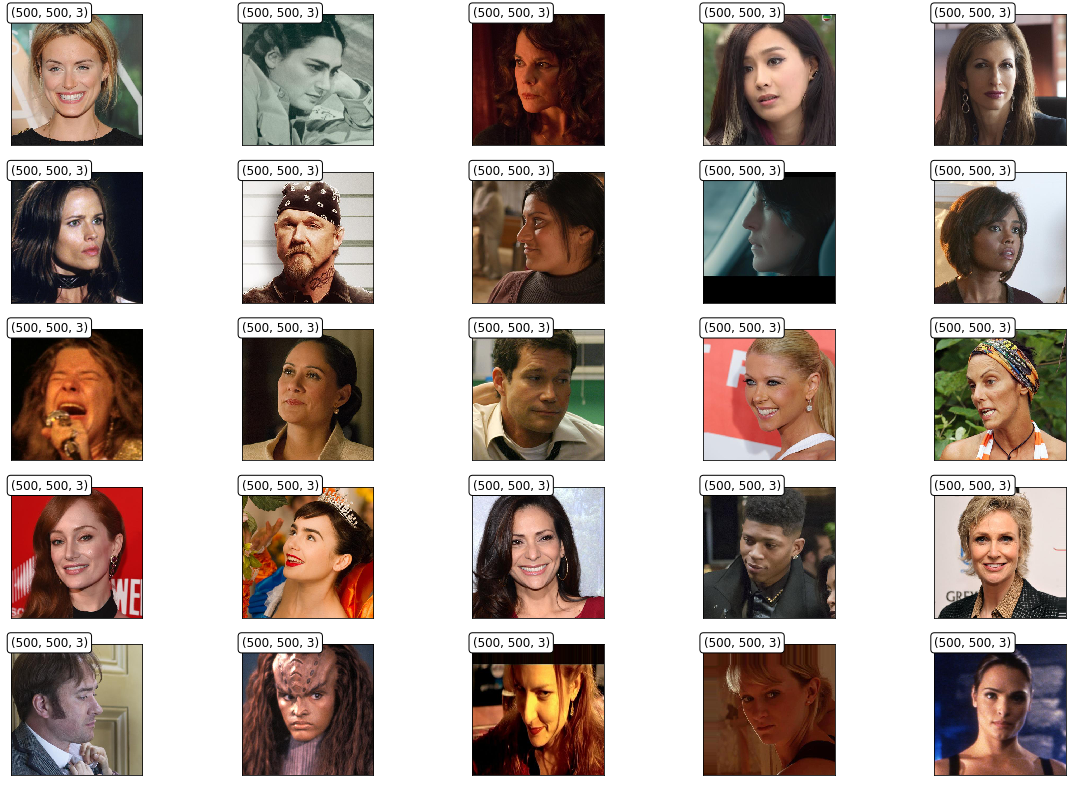

In [36]:
plot_images(df_500_500, 25)

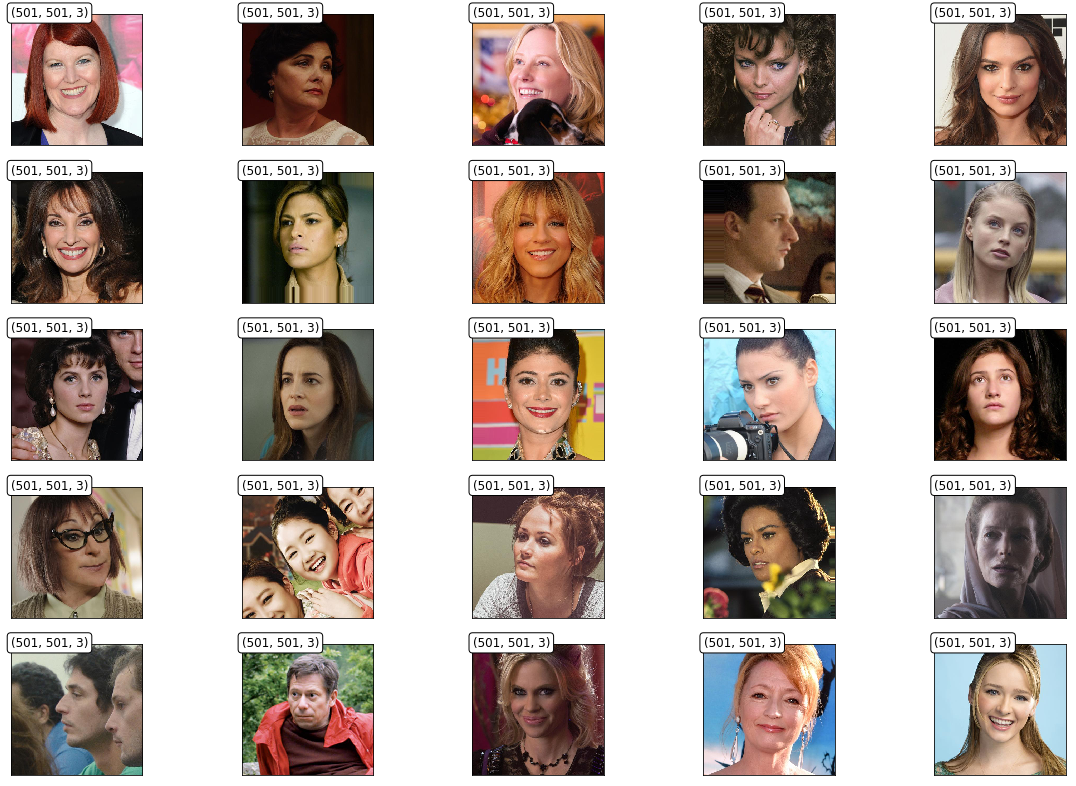

In [37]:
plot_images(df_501_501, 25)

In [38]:
new_meta = meta[(meta['size_W_H'] == '(500, 500)') |
               (meta['size_W_H'] == '(501, 501)')]

In [39]:
new_meta['size_W_H'].value_counts()

(500, 500)    13972
(501, 501)      970
Name: size_W_H, dtype: int64

In [40]:
len(new_meta)

14942

## Label Fns 
We should also try multilabel and a loss function that combines age / gender / ethnicity

## Classify Gender without Augmentation

In [ ]:
tfms = []
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_gender) \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [ ]:
learner = cnn_learner(data, models.vgg19, metrics=[accuracy])
learner.fit_one_cycle(2,1e-3)

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(2,1e-3)

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
#did they change that API ? It was easier previously
'''
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
'''
interp = learner.interpret()
interp.top_losses()
interp.plot_multi_top_losses()

In [ ]:
interp.plot_top_losses(16, heatmap=True)

In [ ]:
m = LayeredModule(get_nested_layers(learner.model))


In [ ]:
m

In [ ]:
tfms

In [ ]:
women = learner.data.x[22].data
women.requires_grad_()
women = women.cuda()
women[None].shape


In [ ]:
nl = NetLens(m, women[None], 0)

In [ ]:
nl.generate_cam("0-0-relu-14")

In [ ]:
model = LayeredModule.from_cnn(models.alexnet(pretrained=True))

original_img, name, target_class = get_example_data(3, img_path='../old_visual/input_images/')

prep_img = preprocess_image(original_img)

prep_img.shape

nl = NetLens(model, prep_img, target_class)

cam = nl.generate_cam('features-relu-4')
cam.shape

nl.show_gradcam('features-relu-4')

## Gender with Augmentation

In [ ]:
tfms = get_transforms(max_rotate=25); 
len(tfms[0]), len(tfms)

In [ ]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_gender) \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [ ]:
l2 = cnn_learner(data, models.resnet18, metrics=[accuracy])
l2.fit_one_cycle(2,1e-3)

In [ ]:
l2.unfreeze()
l2.lr_find()
l2.recorder.plot()

In [ ]:
learner.fit_one_cycle(2,1e-3)

In [ ]:
learner.freeze_to(-2)
l2.lr_find()
l2.recorder.plot()

In [ ]:
learner.fit_one_cycle(2,1e-4)

## Ethnicity 

In [ ]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_race) \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [ ]:
tfms

In [ ]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(2,1e-3)

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(2,1e-3)

In [ ]:
learner.freeze_to(-2)
learner.fit_one_cycle(2,1e-4)

In [ ]:
 learner.interpret().plot_top_losses(6)

## Regression: Age
* using MSEFlatLoss

In [ ]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_age) \
            .transform(tfms)\
            .databunch() \
       )
            #.normalize() )

In [ ]:
def mse_loss(input, targs):    
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return F.mse_loss(input, targs) 

In [ ]:
def logger(func):
    def wrapper(*args, **kwargs):
        out = func(*args, **kwargs)
        print("logging: ", out)
        return out
    return wrapper   

In [ ]:
??mean_squared_error

In [ ]:
def my_mean_squared_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Mean squared error between `pred` and `targ`."
    
    pred,targ = flatten_check(pred,targ)
    out = F.mse_loss(pred, targ)
    print("fastai metrics is never working!! MSE:", out)
    return out

In [ ]:
??cnn_learner

In [ ]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
#not sure this works
learner.loss = my_mean_squared_error


In [ ]:
learner.fit_one_cycle(2,1e-3)

In [ ]:
#FASTAI bug, where it tries to compute with 99 encoded matrix whatever
def mse_loss1(input, target): 
    #_thnn_mse_loss_forward not supported on CUDAType for Long....

    print(input.shape, target.shape, "SHAPES")
    print(target[:8])
    input = torch.argmax(input, dim=1).long().cuda()
    return F.mse_loss(input, target) 